# Лабораторная работа 1 (Малов Алексей 20214)

<img src="/home/l3xxxa/DL/tachki_samples/Lab1.png" alt="KCHAU" width="500" height="500" title="KCHAU">

In [16]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torch.optim as torch_optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from tqdm._tqdm_notebook import tqdm_notebook
import torch.optim as optim
from warnings import filterwarnings

%matplotlib inline

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
class_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

tqdm_notebook.pandas(desc="Progress:")
device = torch.device("cpu")

In [17]:
def show_data(img):
    try:
        plt.imshow(img[0])
    except Exception as e:
        print(e)
    plt.title('y = '+ str(img[1]))
    plt.show()


In [18]:
train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True)
test_set = torchvision.datasets.CIFAR10(root="./data", train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [35]:
train_dataset, validation_dataset = train_test_split(
    train_set, test_size=0.30, random_state=42, stratify=train_set.targets
)
batch_size = 32

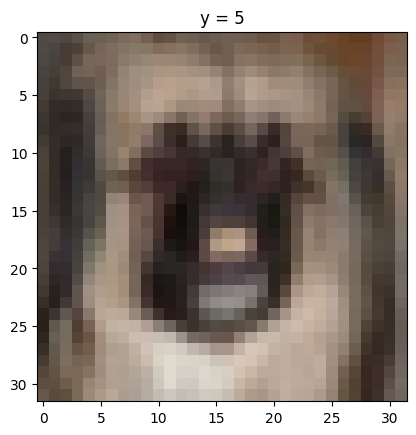

In [36]:
show_data(train_dataset[7])

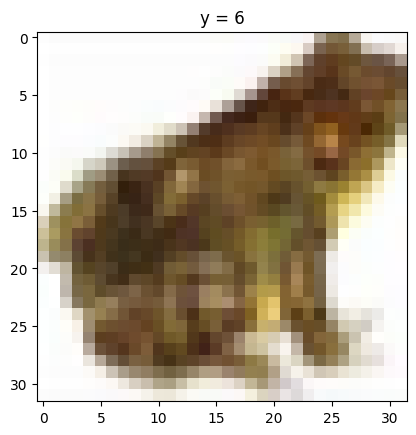

In [37]:
show_data(validation_dataset[3])

легушька)

In [38]:
class DenseModel(nn.Module):
    def __init__(self):
        super(DenseModel, self).__init__()
        self.layer1 = nn.Linear(32*32*3, 512)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        x = self.layer3(x)
        return x

In [40]:
model = DenseModel()
model

DenseModel(
  (layer1): Linear(in_features=3072, out_features=512, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=256, out_features=10, bias=True)
)

In [81]:

def train(model, train_loader, test_loader, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    val_accuracies = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data)
        train_loss = running_loss / len(train_loader)
        train_acc = running_corrects / len(train_loader.dataset)
        train_losses.append(train_loss)        
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss = running_loss / len(test_loader)
        val_losses.append(val_loss)
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        print(f'Epoch {epoch + 1} Train accuracy {train_acc} Training loss: {train_loss} Validation Loss: {val_loss} Validation Accuracy: {val_accuracy}')
    return train_losses, val_losses, val_accuracies

In [82]:
def collate_fn(batch):
    images = []
    labels = []
    for item in batch:
        image, label = item
        images.append(image)
        labels.append(label)
    images = np.stack(images)
    images = torch.from_numpy(images).float()
    labels = torch.tensor(labels)
    return images, labels

In [84]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
train_losses, val_losses, val_accuracies = train(model=model, train_loader=train_loader, test_loader=test_loader, epochs=10, learning_rate=0.0001)

Epoch 1 Train accuracy 0.7094857096672058 Training loss: 0.8190920606282773 Validation Loss: 0.805190807668121 Validation Accuracy: 0.7140571428571428
Epoch 2 Train accuracy 0.7171714305877686 Training loss: 0.8047145493396676 Validation Loss: 0.7909583583392434 Validation Accuracy: 0.7196571428571429
Epoch 3 Train accuracy 0.7188857197761536 Training loss: 0.794783725762498 Validation Loss: 0.7999335776408368 Validation Accuracy: 0.7187714285714286
Epoch 4 Train accuracy 0.722599983215332 Training loss: 0.7866629589846191 Validation Loss: 0.7328903364524981 Validation Accuracy: 0.7422571428571428
Epoch 5 Train accuracy 0.7232000231742859 Training loss: 0.7805290913560055 Validation Loss: 0.7897084710584916 Validation Accuracy: 0.7204571428571429
Epoch 6 Train accuracy 0.7277143001556396 Training loss: 0.7719829340739486 Validation Loss: 0.7598584588528551 Validation Accuracy: 0.7304857142857143
Epoch 7 Train accuracy 0.7337142825126648 Training loss: 0.7545185086931999 Validation Loss

In [86]:
class ConvolutionalNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [91]:
model = ConvolutionalNet()
model

ConvolutionalNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)